In [ ]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset
import torchvision.transforms as tvt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
#class to create Gaussian Noise (referred from https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745)
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
#class which overrides the getitem function of the original CIFAR 10 dataset to create a pair of noisy image and clean image
class ImageDataset(CIFAR10):
  def __init__(self, root, train=True, transform=None, target_transform=None, download=False, sigma=1.0):
    super(ImageDataset, self).__init__(root, train, transform, target_transform, download)
    self.transform_noise=tvt.Compose([tvt.ToTensor(), tvt.Normalize( (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), AddGaussianNoise(0., sigma/255)])
    self.transform_clean=tvt.Compose([tvt.ToTensor(), tvt.Normalize( (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
  def __getitem__(self, idx):
        features, target = super(ImageDataset, self).__getitem__(idx)
        noisy_image = self.transform_noise(features)
        clean_image = self.transform_clean(features)
        return noisy_image, clean_image


In [ ]:
# dCNN model class used by the paper
class dCNN(torch.nn.Module):
  def __init__(self, channels, layers=17):
    super(dCNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3, padding=1, bias=False)
    self.convList = torch.nn.ModuleList()
    for i in range(layers-2):
      self.convList.append(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
      self.convList.append(torch.nn.BatchNorm2d(64))
      self.convList.append(torch.nn.ReLU(inplace=True))
    self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=channels, kernel_size=3, padding=1, bias=False)
  def forward(self, x):
    x = self.conv1(x)
    x = torch.nn.functional.relu(x, inplace=True)
    for conv in self.convList:
      x = conv(x)
    x = self.conv2(x)
    return x


In [ ]:
#function to check PSNR(dB)/SSIM values of the resulted images
def calculate_metrics(image, original, data_range):
    image = image.data.cpu().numpy().astype(np.float32)
    original = original.data.cpu().numpy().astype(np.float32)
    psnr_value = 0
    ssim_value = 0
    for i in range(image.shape[0]):
        psnr_value += psnr(original[i,:,:,:], image[i, :, :, :], data_range=data_range)
        ssim_value += ssim(original[i, :, :, :], image[i, :, :, :], channel_axis=0, data_range=data_range)
    psnr_value /= image.shape[0]
    ssim_value /= image.shape[0]

    return psnr_value, ssim_value

In [ ]:
#training function
def train(model, dataloader, device, epochs, sigma):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    alpha = 0.5
    for epoch in range(epochs):
      running_loss = 0.0
      psnr_value =0.0
      for idx, data in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        noisy_image, clean_image = data
        noisy_image = noisy_image.to(device)
        clean_image = clean_image.to(device)
        D = (sigma/255) * torch.FloatTensor(noisy_image.size()).normal_(mean=0, std=1.).cuda()
        input = noisy_image + alpha*D
        target = noisy_image - D/alpha
        output = model(input)
        loss = criterion(output, target) / target.size()[0]
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        #evaluating the performance per batch
        model.eval()
        output = torch.clamp(model(noisy_image), 0, 1)
        psnr_val, ssim_value = calculate_metrics(output, clean_image, 1.0)
        psnr_value += psnr_val
        if idx % 50 == 0:
          print('Epoch:', epoch + 1, '[', idx+1, '/', len(dataloader), ']', '=>', 'PSNR:', psnr_value/50, 'Loss:', running_loss/50)
          running_loss = 0.0
          psnr_value = 0.0
    file_name = 'model_' + str(sigma) + '.pth'
    torch.save(model.state_dict(), file_name)

In [ ]:
#testing function
def test(dataset, model, model_path, sigma):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    psnr_list = []
    ssim_list = []
    alpha = 0.5
    test_output = None
    for i in range(len(dataset)):
        noisy_image, clean_image = dataset[i]
        noisy_image = torch.unsqueeze(noisy_image,0).to(device)
        clean_image = torch.unsqueeze(clean_image,0).to(device)
        input = noisy_image + alpha * (sigma/255) * torch.FloatTensor(noisy_image.size()).normal_(mean=0, std=1.).cuda()
        with torch.no_grad():
            output = model(input)
        test_output = output.detach() if test_output == None else test_output + output.detach()
        del output
        out = torch.clamp(test_output, 0, 1)
        psnr_val, ssim_value = calculate_metrics(out, clean_image, data_range=1.0)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_value)
    print( 'PSNR of testing dataset:', sum(psnr_list)/len(psnr_list), 'SSIM of testing dataset:', sum(ssim_list)/len(ssim_list))

In [36]:
#function to take one pair of clean and noisy pair of images randomly and compare those against the resultant denoised image
def sample_testing(dataset, model, model_path, sigma):

    model.load_state_dict(torch.load(model_path))
    model.eval()
    idx = random.randint(0, 128)
    noisy_image, clean_image = dataset[idx]
    test_output = None
    noisy_image = torch.unsqueeze(noisy_image,0).to(device)
    clean_image = torch.unsqueeze(clean_image,0).to(device)
    alpha = 0.5
    input = noisy_image + alpha * (sigma/255) * torch.FloatTensor(noisy_image.size()).normal_(mean=0, std=1.).cuda()
    with torch.no_grad():
      output = model(input)
    test_output = output.detach() if test_output == None else test_output + output.detach()
    del output
    out = torch.clamp(test_output, 0, 1)
    psnr_val, ssim_value = calculate_metrics(out, clean_image, data_range=1.0)
    fig,axes = plt.subplots(1,3)
    noisy_image = noisy_image.squeeze().cpu() * torch.tensor([0.247, 0.243, 0.261]).view(3,1,1)
    noisy_image = noisy_image + torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    noisy_image = tvt.ToPILImage()(noisy_image)
    axes[1].imshow(noisy_image)
    axes[1].set_title("Noisy Image")
    clean_image = clean_image.squeeze().cpu() * torch.tensor([0.247, 0.243, 0.261]).view(3,1,1)
    clean_image = clean_image + torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    clean_image = tvt.ToPILImage()(clean_image)
    axes[0].imshow(clean_image)
    axes[0].set_title("Clean Image")
    out_image = out.squeeze().cpu() * torch.tensor([0.247, 0.243, 0.261]).view(3,1,1)
    out_image = out_image + torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    out_image = tvt.ToPILImage()(out_image)
    axes[2].imshow(out_image)
    axes[2].set_title("Denoised Image")

    fig.suptitle("PSNR: " + str(round(psnr_val,2)) + " SSIM: " +  str(round(ssim_value,2)) + ' when σ=' + str(sigma))
    plt.show()


In [ ]:
#main pipeline

# setting up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# training dataset
training_dataset_25 = ImageDataset("./training", train=True , download=True, sigma=25)
training_dataset_50 = ImageDataset("./training", train=True , download=True, sigma=50)
# testing dataset
testing_dataset_25 = ImageDataset("./testing", train=False, download=True, sigma=25)
testing_dataset_50 = ImageDataset("./testing", train=False, download=True, sigma=50)
# training dataloader
train_DL_25 = torch.utils.data.DataLoader(training_dataset_25, batch_size=128, shuffle=True, num_workers=6)
train_DL_50 = torch.utils.data.DataLoader(training_dataset_50, batch_size=128, shuffle=True, num_workers=6)
# testing dataloader (not needed)
test_DL_25 = torch.utils.data.DataLoader(testing_dataset_25, batch_size=128, shuffle=True, num_workers=2)
test_DL_50 = torch.utils.data.DataLoader(testing_dataset_50, batch_size=128, shuffle=True, num_workers=2)
#initialze the model
model = dCNN(channels=3)

100%|██████████| 170498071/170498071 [00:03<00:00, 53827756.12it/s]


Extracting ./training/cifar-10-python.tar.gz to ./training
Files already downloaded and verified


100%|██████████| 170498071/170498071 [00:02<00:00, 80835375.77it/s]


Extracting ./testing/cifar-10-python.tar.gz to ./testing
Files already downloaded and verified


In [ ]:
# training the model with sigma = 25
train(model, train_DL_25, device, 50, 25)    #trained model saved in model_25.pth
# training the model with sigma = 50
train(model, train_DL_50, device, 50, 50)    #trained model saved in model_50.pth

Epoch: 1 [ 1 / 391 ] => PSNR: 0.006950741814265401 Loss: 0.00019082721322774887
Epoch: 1 [ 51 / 391 ] => PSNR: 1.8909468080947767 Loss: 0.0020008876849897206
Epoch: 1 [ 101 / 391 ] => PSNR: 3.3718694367452695 Loss: 0.0008958170062396676
Epoch: 1 [ 151 / 391 ] => PSNR: 3.5303058728214554 Loss: 0.0007717895798850804
Epoch: 1 [ 201 / 391 ] => PSNR: 3.5247656983465436 Loss: 0.0007154754246585071
Epoch: 1 [ 251 / 391 ] => PSNR: 3.547472290663858 Loss: 0.0006190253642853349
Epoch: 1 [ 301 / 391 ] => PSNR: 3.629680941664196 Loss: 0.0005848160840105266
Epoch: 1 [ 351 / 391 ] => PSNR: 3.601131927434182 Loss: 0.0005901700537651777
Epoch: 2 [ 1 / 391 ] => PSNR: 0.06864769482275125 Loss: 1.1031590402126312e-05
Epoch: 2 [ 51 / 391 ] => PSNR: 3.6956391008939646 Loss: 0.0005557156889699399
Epoch: 2 [ 101 / 391 ] => PSNR: 3.6282162186519544 Loss: 0.0005565435497555882
Epoch: 2 [ 151 / 391 ] => PSNR: 3.662615178810221 Loss: 0.0005489725596271455
Epoch: 2 [ 201 / 391 ] => PSNR: 3.605334380397701 Loss: 0

In [ ]:
# testing the mode with sigma = 25
test(testing_dataset_25, model, "./model_25.pth", 25)
# testing the mode with sigma = 50
test(testing_dataset_50, model,  "./model_50.pth", 50)

PSNR of testing dataset: -0.7481143250011181 SSIM of testing dataset: 0.008110882446255345
PSNR of testing dataset: -0.9008952740481616 SSIM of testing dataset: 0.00854114420345213


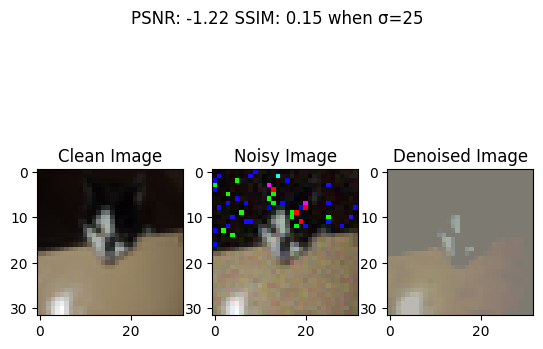

In [83]:
sample_testing(testing_dataset_25, model, "./model_25.pth", 25)

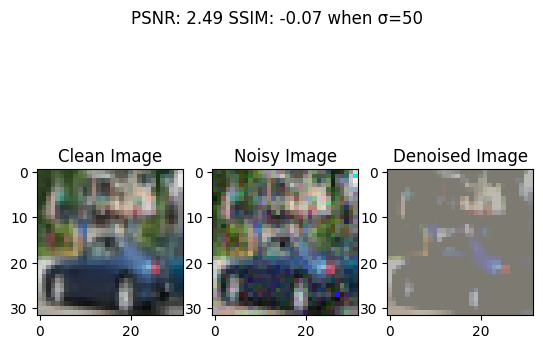

In [72]:
sample_testing(testing_dataset_50, model, "./model_50.pth", 50)